# Образец работы стратегии
В этом файле представлен образец простешей стратегии.

Формат самого файла - notebook, записная книжка. Это специальный формат файлов, в котором каждый кусочек кода можно исполнять отдельно.

Для того, чтобы исполнить ячейку - нужно нажать Shift+Enter. После одиночного нажатия активной ячейкой ставится следующая. Для работы достаточно поочередно понажимать эту комбинацию до последней ячейки, где и запустится основная программа.

# Добавляем директорию основной папки в PATH
## Посмотрите как это можно пофиксить. Возможно на проде такого не будет
Здесь Python понимает, что ему нужно обращать внимание на главную папку с библиотекой. Ничего дополнительно нажимать не надо, только исполнить ячейку.

In [1]:
import sys
import os

path = os.getcwd()
repo_folder = os.path.dirname(os.path.dirname(path))
sys.path.append(repo_folder)
!set PATH=%PATH%;%APPDATA%\Python\Scripts

# Загружаем все необходимые библиотеки для запуска скрипта
Здесь загружаются основные библиотеки для работы программы.
Загрузки представлены в виде "from ... import ...". Это значит, что из библиотеки decimal (from decimal) мы загружаем функционад Decimal (import Decimal). Это может как отдельные спецфункции, так и сложные алгоритмы.

In [2]:
import logging

from tinkoff.invest.mock_services import MockedClient
from decimal import Decimal
from tinkoff.invest.strategies.moving_average.strategy_settings import (
    MovingAverageStrategySettings,
)
from tinkoff.invest import CandleInterval, MoneyValue
from tinkoff.invest.strategies.moving_average.signal_executor import (
    MovingAverageSignalExecutor,
)
from tinkoff.invest.strategies.moving_average.supervisor import (
    MovingAverageStrategySupervisor,
)
from tinkoff.invest.strategies.moving_average.strategy_state import (
    MovingAverageStrategyState,
)
from tinkoff.invest.strategies.moving_average.strategy import MovingAverageStrategy
from tinkoff.invest.strategies.moving_average.trader import MovingAverageStrategyTrader
from datetime import timedelta, datetime, timezone
from tinkoff.invest.typedefs import ShareId, AccountId
from tinkoff.invest.strategies.base.account_manager import AccountManager
from tinkoff.invest.strategies.moving_average.plotter import (
    MovingAverageStrategyPlotter,
)


logging.basicConfig(format="%(asctime)s %(levelname)s:%(message)s", level=logging.INFO)
logger = logging.getLogger(__name__)

# Загружаем токен
Здесь мы указываем токен для работы с программой.
Токен - этой такой ключ-идентификатор, который позволяет программе понять что вы это вы.
Инструкция здесь: https://www.tinkoff.ru/invest/open-api/

Для работы нам нужен sandbox токен.

Sandbox - это такая внутрення виртуальная площадка, на которой ценовые и потоковые данные полностью совпадают с реальным рынком, но портфель и заявки могут быть заданы самим пользователем. Эдакая песочница (что и отражено в названии) для того, чтобы испытать интерфейс и инфраструктуру без угрозы настоящему аккаунту с настоящими деньгами.

При получении sandbox токена вы не рискуете ничем, кроме виртуальных денег на вашем счете :)

In [3]:
# sandbox token
token = "t.E3viNwX9Vep411fSuY_l4Dcht-0hIBWSnJ9dPW_Wh0DWYHlBJk1xul-Pz0FsepED7Uz5gSdJ93vMXYBdplwN4A"

# Раздел с настройками
Здесь вводятся основные настройки стратегии, по которой будут определяться сигналы.

Стратегия основана на том, что цена время от времени возвращается к своей длинной средней. Если в это время зайти по направлению этой средней, то можно совершить достаточно эффективную сделку с точки зрения прибыль/убытка.

Для запуска стратегии необходимо задать следующие параметры:

 - long_ma - количество периодов для расчета длинной скользяшки
 - short_ma - количество периодов для расчета короткой скользяшки
 - std_period - количество периодов для расчета волатильности инструмента
 - timeframe - выбранная размерность свечей для расчета
 
 В переменную stocks записываются акции, на которых будет тестироваться стратегия.

In [7]:
long_ma = 240
short_ma = 60
std_period = 30
timaframe = CandleInterval.CANDLE_INTERVAL_1_MIN
n, m, s, tf = long_ma, short_ma, std_period, timaframe
period = 1  # сюда добавить переход от tf к числу или отрекдактировать код снизу

stocks = {
    "AAPL": {"figi": "BBG000B9XRY4"},
    "MSFT": {"figi": "BBG000BPH459"},
    # "GOOG":{"figi":"BBG009S3NB30"}, гугл не работает
    "AMZN": {"figi": "BBG000BVPV84"},
    "TSLA": {"figi": "BBG000N9MNX3"},
}

# Блок с определением дат для бектестинга
Здесь задаются временные пределы для даты, на котором будет производиться бектестинг (проверка на исторических данных).

По умолчанию задаются как зависимости от количества периодов.

In [11]:
def start_datetime() -> datetime:
    return datetime(year=2022, month=2, day=1, hour=17, tzinfo=timezone.utc)


# тут надо проставлять сдвиг даты в зависимости от выбранного тф
# что-то вроде CandleInterval.CANDLE_INTERVAL_1_MIN.seconds * (m+n) для real_market_data_test_from
real_market_data_test_from = start_datetime() - timedelta(
    minutes=(n + m) * 2
)  # с какой даты начинают считаться индикаторы
real_market_data_test_start = (
    start_datetime()
)  # с какой даты начинает работать стратегия
real_market_data_test_end = start_datetime() + timedelta(
    days=2
)  # когда все заканчивается

# Запуск бектестинга
В этой ячейке основной исполняемый код для проверки стратегии. В конце определяется инструмент, для которого наилучшим образом подходит данная стратегия

По завершении стратегии можно вызывать картинку с графиком цены акции и сделками (если были).

## Обеспечить такой выбор через обращение к полю events в виде events(best_stock)

In [12]:
balances = {}

for stock in stocks:

    figi = ShareId(stocks[stock]["figi"])

    balance = MoneyValue(currency="rub", units=20050, nano=690000000)

    account_id = AccountId("1337007228")
    settings = MovingAverageStrategySettings(
        share_id=figi,  # figi конкретной ценной бумаги
        account_id=account_id,  # неважно для sandbox
        max_transaction_price=Decimal(
            10000
        ),  # максимальный объем сделки - зависит от размера портфеля. сейчас фиксировано
        candle_interval=tf,  # тф - таймфрейм
        long_period=timedelta(minutes=n * period),  # длинная скользяшка
        short_period=timedelta(minutes=m * period),  # короткая скользяшка
        std_period=timedelta(minutes=s * period),  # количество периодов для стд
    )

    with MockedClient(
        token=token,
        settings=settings,
        real_market_data_test_from=real_market_data_test_from,
        real_market_data_test_start=real_market_data_test_start,
        real_market_data_test_end=real_market_data_test_end,
        balance=balance,
    ) as mocked_services:
        account_manager = AccountManager(
            services=mocked_services, strategy_settings=settings
        )
        state = MovingAverageStrategyState()
        strategy = MovingAverageStrategy(
            settings=settings,
            account_manager=account_manager,
            state=state,
        )
        supervisor = MovingAverageStrategySupervisor()
        signal_executor = MovingAverageSignalExecutor(
            services=mocked_services,
            state=state,
            settings=settings,
        )
        moving_average_strategy_trader = MovingAverageStrategyTrader(
            strategy=strategy,
            settings=settings,
            services=mocked_services,
            state=state,
            signal_executor=signal_executor,
            account_manager=account_manager,
            supervisor=supervisor,
        )
        plotter = MovingAverageStrategyPlotter(settings=settings)

        initial_balance = account_manager.get_current_balance()

        for i in range(50):
            logger.info("Trade %s", i)
            moving_average_strategy_trader.trade()

    balances[stock] = balance.units

best_stock = max(balances, key=balances.get)
best_stock

2022-02-01 20:00:00,000 INFO:5f7a771f14f01b5b76ac68ea714f344a GetCandles
2022-02-01 20:00:00,000 INFO:5635e1dbaa249a58e111c29dae684006 GetCandles
2022-02-01 20:00:00,000 INFO:fb56d92d981e55d59805908a21abce24 GetCandles
2022-02-01 20:00:00,000 INFO:Loading candles for period 5:00:00 from 2022-02-01 17:00:00+00:00
2022-02-01 20:00:00,000 INFO:Marginal trade is active
2022-02-01 20:00:00,000 INFO:Got enough data for strategy
2022-02-01 20:00:00,000 INFO:Trade 0
2022-02-01 20:00:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:00:00,000 INFO:Refreshing data
2022-02-01 20:00:00,000 INFO:Data refreshed
2022-02-01 20:00:00,000 INFO:Strategy predict
2022-02-01 20:00:00,000 INFO:Got signals [OpenLongMarketOrder(lots=115, direction=<SignalDirection.LONG: 'LONG'>)]
2022-02-01 20:00:00,000 INFO:Trying to execute signal OpenLongMarketOrder(lots=115, direction=<SignalDirection.LONG: 'LONG'>)
2022-02-01 20:00:00,000 WARNING:Operation: OrderDirection.ORDER_DIRECTION_BUY, -20026.10000000
2022-02-01 20

2022-02-01 20:32:00,000 INFO:Trade 33
2022-02-01 20:32:00,000 INFO:Balance: 24.59000000
2022-02-01 20:32:00,000 INFO:Refreshing data
2022-02-01 20:33:00,000 INFO:Data refreshed
2022-02-01 20:33:00,000 INFO:Strategy predict
2022-02-01 20:33:00,000 INFO:Trade 34
2022-02-01 20:33:00,000 INFO:Balance: 24.59000000
2022-02-01 20:33:00,000 INFO:Refreshing data
2022-02-01 20:34:00,000 INFO:Data refreshed
2022-02-01 20:34:00,000 INFO:Strategy predict
2022-02-01 20:34:00,000 INFO:Trade 35
2022-02-01 20:34:00,000 INFO:Balance: 24.59000000
2022-02-01 20:34:00,000 INFO:Refreshing data
2022-02-01 20:35:00,000 INFO:Data refreshed
2022-02-01 20:35:00,000 INFO:Strategy predict
2022-02-01 20:35:00,000 INFO:Trade 36
2022-02-01 20:35:00,000 INFO:Balance: 24.59000000
2022-02-01 20:35:00,000 INFO:Refreshing data
2022-02-01 20:36:00,000 INFO:Data refreshed
2022-02-01 20:36:00,000 INFO:Strategy predict
2022-02-01 20:36:00,000 INFO:Trade 37
2022-02-01 20:36:00,000 INFO:Balance: 24.59000000
2022-02-01 20:36:00,

2022-02-01 20:14:00,000 INFO:Strategy predict
2022-02-01 20:14:00,000 INFO:Trade try complete
2022-02-01 20:14:00,000 INFO:Trade 15
2022-02-01 20:14:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:14:00,000 INFO:Refreshing data
2022-02-01 20:15:00,000 INFO:Data refreshed
2022-02-01 20:15:00,000 INFO:Strategy predict
2022-02-01 20:15:00,000 INFO:Trade try complete
2022-02-01 20:15:00,000 INFO:Trade 16
2022-02-01 20:15:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:15:00,000 INFO:Refreshing data
2022-02-01 20:16:00,000 INFO:Data refreshed
2022-02-01 20:16:00,000 INFO:Strategy predict
2022-02-01 20:16:00,000 INFO:Trade try complete
2022-02-01 20:16:00,000 INFO:Trade 17
2022-02-01 20:16:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:16:00,000 INFO:Refreshing data
2022-02-01 20:17:00,000 INFO:Data refreshed
2022-02-01 20:17:00,000 INFO:Strategy predict
2022-02-01 20:17:00,000 INFO:Trade try complete
2022-02-01 20:17:00,000 INFO:Trade 18
2022-02-01 20:17:00,000 INFO:Balance: 20050.69

2022-02-01 20:44:00,000 INFO:Strategy predict
2022-02-01 20:44:00,000 INFO:Trade try complete
2022-02-01 20:44:00,000 INFO:Trade 45
2022-02-01 20:44:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:44:00,000 INFO:Refreshing data
2022-02-01 20:45:00,000 INFO:Data refreshed
2022-02-01 20:45:00,000 INFO:Strategy predict
2022-02-01 20:45:00,000 INFO:Got signals [OpenShortMarketOrder(lots=65, direction=<SignalDirection.SHORT: 'SHORT'>)]
2022-02-01 20:45:00,000 INFO:Trying to execute signal OpenShortMarketOrder(lots=65, direction=<SignalDirection.SHORT: 'SHORT'>)
2022-02-01 20:45:00,000 WARNING:Operation: OrderDirection.ORDER_DIRECTION_SELL, 19919.25000000
2022-02-01 20:45:00,000 INFO:Signal executed OpenShortMarketOrder(lots=65, direction=<SignalDirection.SHORT: 'SHORT'>)
2022-02-01 20:45:00,000 INFO:Trade 46
2022-02-01 20:45:00,000 INFO:Balance: 39969.94000000
2022-02-01 20:45:00,000 INFO:Refreshing data
2022-02-01 20:46:00,000 INFO:Data refreshed
2022-02-01 20:46:00,000 INFO:Strategy pre

2022-02-01 20:20:00,000 WARNING:Operation: OrderDirection.ORDER_DIRECTION_BUY, -17977.44000000
2022-02-01 20:20:00,000 INFO:Signal executed CloseShortMarketOrder(lots=6, direction=<SignalDirection.SHORT: 'SHORT'>)
2022-02-01 20:20:00,000 INFO:Trying to execute signal OpenLongMarketOrder(lots=12, direction=<SignalDirection.LONG: 'LONG'>)
2022-02-01 20:20:00,000 WARNING:Operation: OrderDirection.ORDER_DIRECTION_BUY, -35954.88000000
2022-02-01 20:20:00,000 INFO:Signal executed OpenLongMarketOrder(lots=12, direction=<SignalDirection.LONG: 'LONG'>)
2022-02-01 20:20:00,000 INFO:Trade 21
2022-02-01 20:20:00,000 INFO:Balance: -15942.71000000
2022-02-01 20:20:00,000 INFO:Refreshing data
2022-02-01 20:21:00,000 INFO:Data refreshed
2022-02-01 20:21:00,000 INFO:Strategy predict
2022-02-01 20:21:00,000 INFO:Trade 22
2022-02-01 20:21:00,000 INFO:Balance: -15942.71000000
2022-02-01 20:21:00,000 INFO:Refreshing data
2022-02-01 20:22:00,000 INFO:Data refreshed
2022-02-01 20:22:00,000 INFO:Strategy pred

2022-02-01 20:01:00,000 INFO:Refreshing data
2022-02-01 20:02:00,000 INFO:Data refreshed
2022-02-01 20:02:00,000 INFO:Strategy predict
2022-02-01 20:02:00,000 INFO:Trade try complete
2022-02-01 20:02:00,000 INFO:Trade 3
2022-02-01 20:02:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:02:00,000 INFO:Refreshing data
2022-02-01 20:03:00,000 INFO:Data refreshed
2022-02-01 20:03:00,000 INFO:Strategy predict
2022-02-01 20:03:00,000 INFO:Trade try complete
2022-02-01 20:03:00,000 INFO:Trade 4
2022-02-01 20:03:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:03:00,000 INFO:Refreshing data
2022-02-01 20:04:00,000 INFO:Data refreshed
2022-02-01 20:04:00,000 INFO:Strategy predict
2022-02-01 20:04:00,000 INFO:Trade try complete
2022-02-01 20:04:00,000 INFO:Trade 5
2022-02-01 20:04:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:04:00,000 INFO:Refreshing data
2022-02-01 20:05:00,000 INFO:Data refreshed
2022-02-01 20:05:00,000 INFO:Strategy predict
2022-02-01 20:05:00,000 INFO:Trade try complet

2022-02-01 20:31:00,000 INFO:Refreshing data
2022-02-01 20:32:00,000 INFO:Data refreshed
2022-02-01 20:32:00,000 INFO:Strategy predict
2022-02-01 20:32:00,000 INFO:Trade try complete
2022-02-01 20:32:00,000 INFO:Trade 33
2022-02-01 20:32:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:32:00,000 INFO:Refreshing data
2022-02-01 20:33:00,000 INFO:Data refreshed
2022-02-01 20:33:00,000 INFO:Strategy predict
2022-02-01 20:33:00,000 INFO:Trade try complete
2022-02-01 20:33:00,000 INFO:Trade 34
2022-02-01 20:33:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:33:00,000 INFO:Refreshing data
2022-02-01 20:34:00,000 INFO:Data refreshed
2022-02-01 20:34:00,000 INFO:Strategy predict
2022-02-01 20:34:00,000 INFO:Trade try complete
2022-02-01 20:34:00,000 INFO:Trade 35
2022-02-01 20:34:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:34:00,000 INFO:Refreshing data
2022-02-01 20:35:00,000 INFO:Data refreshed
2022-02-01 20:35:00,000 INFO:Strategy predict
2022-02-01 20:35:00,000 INFO:Trade try comp

'MSFT'

# Вывод картинки

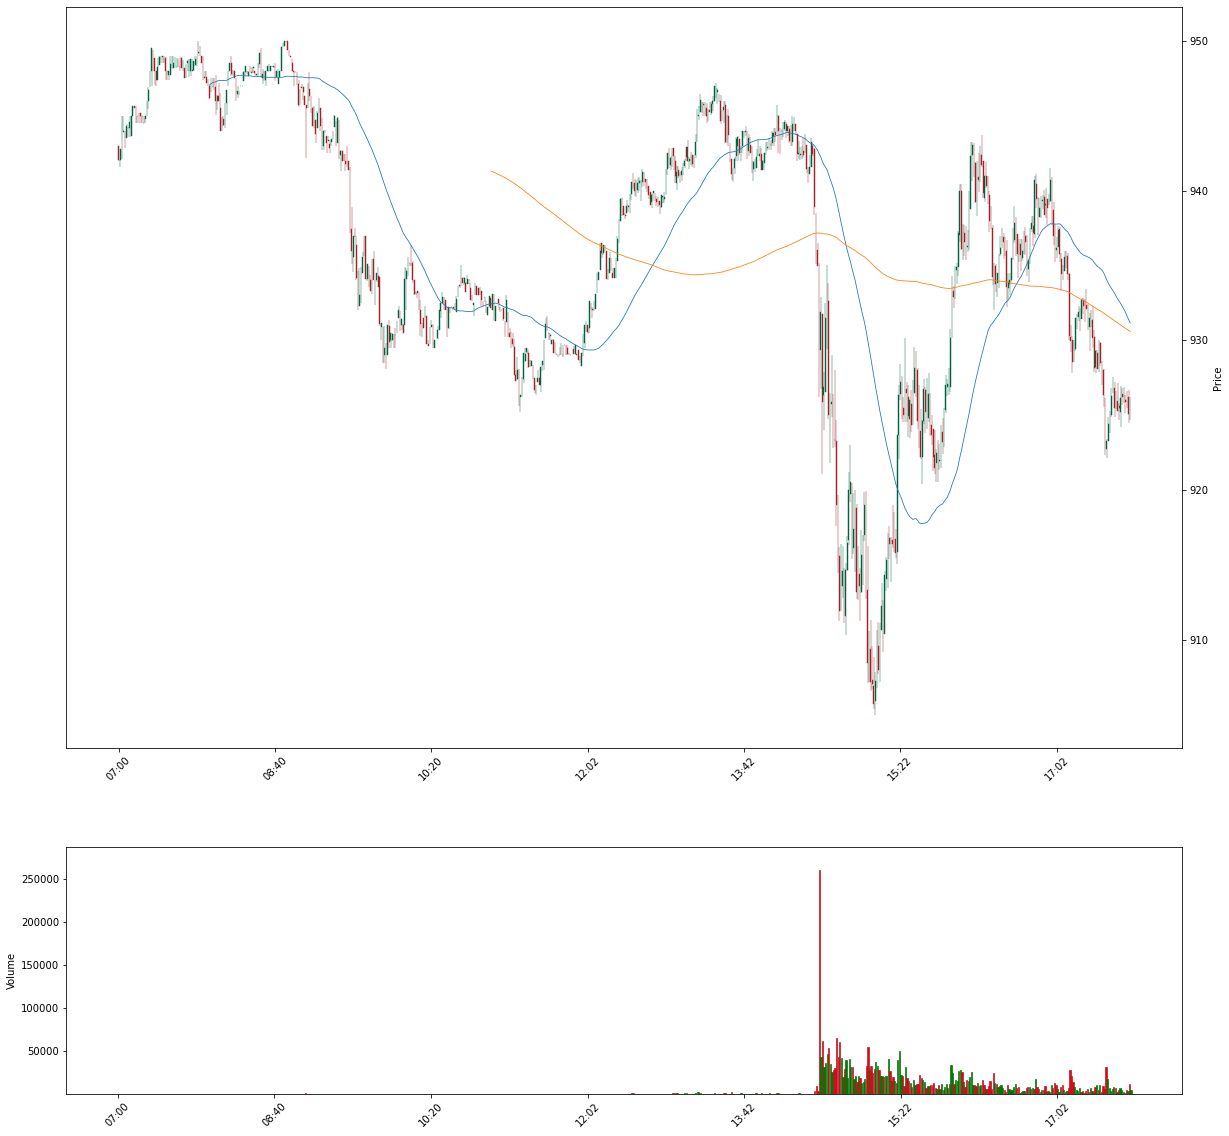

In [13]:
events = supervisor.get_events()
plotter.plot(events)

current_balance = account_manager.get_current_balance()
# assert initial_balance != current_balance
# logger.info("Initial balance %s", initial_balance)
# logger.info("Current balance %s", current_balance)